# Neural Style Transfer
This notebook was made for the "Deep Learning Art Generation" workshop held by the digital agency  [Uppercase](http://www.uppercase.no) (we're hiring!) in collaboration with [Women In Tech Oslo](https://www.facebook.com/WomenITech/) on April 30th 2019.

The notebook was written by Idir Berg Ould-Saada and Aleksander Bai. 

The work is based on the paper [A Neural Algorithm of Artistic Style](http://arxiv.org/abs/1508.06576).
The code is inspired by [Keras](https://keras.io/examples/neural_style_transfer/) and [Deeplearning.ai](https://www.coursera.org/specializations/deep-learning).

Check out the presentation [here](https://docs.google.com/presentation/d/1T76YYZYeshXBNtWp2Jfjitl6yc6lpMiBxc7SsXTk5Kc/edit?usp=sharing).

Put your creations [here](https://docs.google.com/document/d/1T1ZubS6TuT3iHPdKhXvvxMp9IRLj4FQ8x1VT0l-QNmI)

## How to use this notebook
You can run the whole notebook by clicking *Runtime -> Run all* in the menu or typing "CMD/CTRL + F9".

You can run one cell by selecting it and typing *SHIFT + ENTER*.

To make sure you're using a GPU, click *Runtime -> Change runtime type*, and make sure it says "Python 3" and "GPU". This will make the algorithm run a lot faster!

The notebook automatically downloads some sample images, but you can upload you own by clicking "UPLOAD" in the "Files" column to the left.

To experiment with parameters and create you personal art, you could:
- Change input images. They should be similar in size and aspect ratio for the best results
- Change weights STYLE_WEIGHT, CONTENT_WEIGHT and VARIATION_WEIGHT to prioritize differently in the optimization
- Change img_h to make images larger (takes more time)
- Change content_layer and style_layers to see the effect of using different layers for style and content.
- Change the initial generated image base and noise ratio

All of these variables are defined under the "Define constants" section.

Different images may require different parameters to perform optimally!


## Our goal
![goal](https://lh5.googleusercontent.com/1LGf_aQInES9CynJg8neNyUsD1BRVAie_1NB8soRfxvx7uBSrQ5npfy76BO1CzS8FoczPNyyayhoFFaz5Sd6ryfZ8QkrQ17SuzM3TPmrAyABqRU39igOO9pe39hDXF8O4MS1VM27Zm0)

## Imports
First, we need to import the right functions and download some sample images.

In [0]:
import time
import numpy as np
import tensorflow.contrib.keras.api.keras.backend as K
from scipy.misc import imsave, imresize
from PIL import Image
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.contrib.keras.api.keras.applications import vgg16
from tensorflow.contrib.keras.api.keras.preprocessing.image import load_img, img_to_array
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore") # Ignore warnings

In [0]:
!mkdir output #Create an output folder

# Download some sample images
!wget -O vangogh.jpg "https://drive.google.com/open?id=1frSPWSYV25Yq2_-89WBCDaAXEeiWpoFW"
!wget -O opera.jpg "https://drive.google.com/open?id=1l4u8LMIgHZmiyp55IZBc1gEjnMo6vovQ"

--2019-04-30 16:42:01--  https://drive.google.com/open?id=1frSPWSYV25Yq2_-89WBCDaAXEeiWpoFW
Resolving drive.google.com (drive.google.com)... 108.177.112.102, 108.177.112.100, 108.177.112.113, ...
Connecting to drive.google.com (drive.google.com)|108.177.112.102|:443... connected.
HTTP request sent, awaiting response... 307 OK
Location: https://drive.google.com/file/d/1frSPWSYV25Yq2_-89WBCDaAXEeiWpoFW/view?usp=drive_open [following]
--2019-04-30 16:42:06--  https://drive.google.com/file/d/1frSPWSYV25Yq2_-89WBCDaAXEeiWpoFW/view?usp=drive_open
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘vangogh.jpg’

vangogh.jpg             [ <=>                ] 131.65K  --.-KB/s    in 0.01s   

2019-04-30 16:42:06 (10.3 MB/s) - ‘vangogh.jpg’ saved [134814]

--2019-04-30 16:42:07--  https://drive.google.com/open?id=1l4u8LMIgHZmiyp55IZBc1gEjnMo6vovQ
Resolving drive.google.com (drive.google.com)... 74.125.12

## Define constants

### Import images

Then, we need to choose the images we want to use. 

CONTENT_IMG_PATH should be the path to the image defining the content. This could for example be an image of you.

STYLE_IMG_PATH should be the path to the image defining the style. This could for example be a painting.

You can upload these images on the left by clicking "UPLOAD"!

In [0]:
# Define constants
CONTENT_IMG_PATH = 'photo.jpg'
STYLE_IMG_PATH = '2148_10.jpg'
OUTPUT_PATH = 'gen_img.jpg'

# Define the shape of the output image
h, w = load_img(CONTENT_IMG_PATH).size
img_h = 300
img_w = int(h * img_h / w)

### Constants
Now, we need to define some constants. You can play with these to change the final output

In [0]:
# Number of iterations to run
ITER = 5

# Weights of losses. How important are they against each other?
CONTENT_WEIGHT = 0.0025
STYLE_WEIGHT = 1.0
VARIATION_WEIGHT = 1.0

# Noise ratio and base image for initial gen image
NOISE_RATIO = 0.6
INITIAL_GEN_IMAGE = CONTENT_IMG_PATH

# Content and 
CONTENT_LAYER = 'block4_conv2'
STYLE_LAYERS = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

### We're using VGG16 as our pretrained network
![VGG16](https://lh3.googleusercontent.com/QH4CdtlhvQWQ0d0Q6DWBIliHtzGS9iAxH2zBlZhsGUnrNroNmAKgUmZ5B_QLNajU6HHoVy4QImhLK881Fy0jQYOurKpZbDkYeRlXhq856mvlNyoAeXJ8AzAUqwTvUfTGPjKmVLcBy6o)

### View images

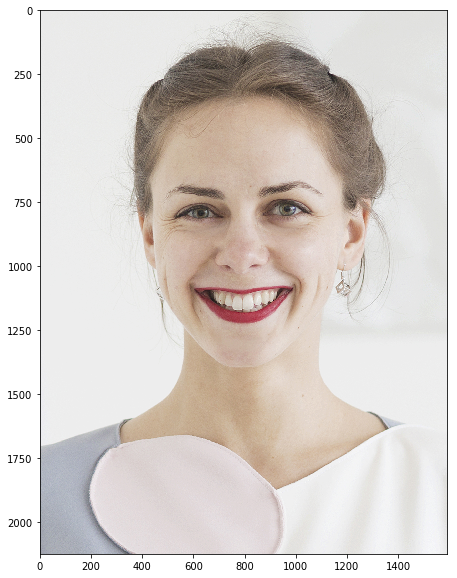

In [0]:
plt.figure(figsize = (10,10))
imshow(load_img(CONTENT_IMG_PATH))
plt.show()

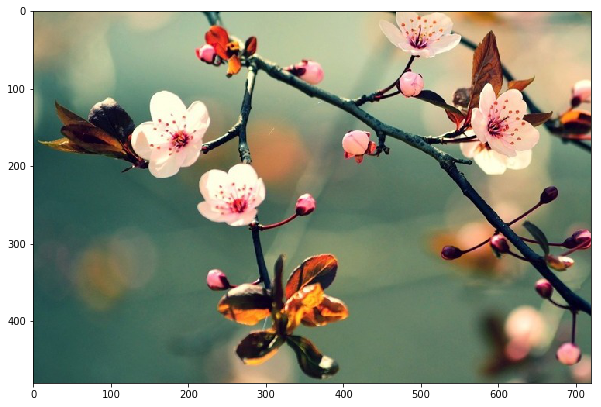

In [0]:
plt.figure(figsize = (10,10))
imshow(load_img(STYLE_IMG_PATH))
plt.show()

## Define some helper functions

### Transform images

We will need to load the images from file and make sure they are saved in the right shape to be used as input for the neural network. 

This is done by the two following functions: 

- *preprocess* which loads an image from file and reshapes it to make it ready for the neural network, 

- *deprocess_image* which does the opposite transformation so we can view and save the generated images.

Don't worry about the details here if you don't understand. It should just work :) 

In [0]:
# Preprocessing to load the image and transform it into the 
# right shape for the neural network
def preprocess(img_path):
    img = load_img(img_path)
    img = img_to_array(img)
    
    # Resize image
    img = imresize(img, (img_h, img_w, 3))
    img = img.astype('float64')
    
    # Add the batch dimension
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img


In [0]:
# Takes and image generated by the neural network and 
# tranforms is to we can view and save it
def deprocess_image(img):
    img = img.reshape((img_h, img_w, 3))
    # Remove zero-center by mean pixel
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype('uint8')
    return img


In [0]:
# Adding noise to the initial generated image may help getting a better result.
def add_noise(content_image, noise_ratio=1):
  noise_image = np.random.uniform(-20, 20, content_image.shape).astype('float32')
  return noise_ratio * noise_image + (1 - noise_ratio) * content_image

## Define model
![Style Transfer](https://lh3.googleusercontent.com/W4Q6rfzMljd09GrfNEnIl7qQEqIJ0cfcTcSyjx77_kC8oEdNmJF9UbPDqGjE5ljAVWPezcjK8eGyolME6Y449MMyt5A1OmbX9P_i2chT=s1600)

### Define input variables


In [0]:
# Create Keras variables of input images
content_img = K.variable(preprocess(CONTENT_IMG_PATH))
style_img = K.variable(preprocess(STYLE_IMG_PATH))

# Since we don't have the generated image yet, we use a placeholder variable
gen_img = K.placeholder(shape=(1, img_h, img_w, 3))

# Create a single tensor containing all three images.
input_tensor = K.concatenate([content_img, style_img, gen_img], axis=0)

### Load pretrained model

In [0]:
# Create a vgg19 model by running the input tensor though the vgg19 convolutional
# neural network, excluding the fully connected layers
model = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)
print('Model loaded')

# Create an output dictionary
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

#Define function to easily get the output of a layer
def get_layer_output(layer_name, image_type):
  return {
      'content': outputs_dict[layer_name][0, :, :, :],
      'style': outputs_dict[layer_name][1, :, :, :],
      'generated': outputs_dict[layer_name][2, :, :, :]
  }[image_type]

Model loaded


## Define loss functions

### Find Style Loss
![Style Loss](https://lh4.googleusercontent.com/MaOmTKEaK40CahH8bhgzoiUgA4wyOTFT1MH57A2iSFhQERK3JBK-r91ynN9c8nqbag2P9NR0APZFKHTRsFTx3zxhONr-m3nXk3Rg4Z9H1ebqN9rj9f9uC618SM2nhr5AO3lcJRs6s4Q)

In [0]:
# This defines the 'style' of an image (x) as a bunch of numbers (matrix)
def style_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # Dot product of the flattened feature map and the transpose of the
    # flattened feature map
    gram = K.dot(features, K.transpose(features))
    return gram

In [0]:
# Think of this as: 
# "How different is the style of the generated image from the style of the 'style' image?"
def style_loss(style, gen):
    assert K.ndim(style) == 3
    assert K.ndim(gen) == 3
    S = style_matrix(style)
    G = style_matrix(gen)
    channels = 3
    size = img_h * img_w
    # Euclidean distance of the style matrices multiplied by the constant
    return K.sum(K.square(S - G)) / (4. * (channels ** 2) * (size ** 2))

### Find Content Loss
![Content Loss](https://lh3.googleusercontent.com/Mxlnuac256JHptQHqlKlYuhCJcbH7gCOpfc8uuDVemvMEc7Q_N5ViMU0XfaNI4QNZPpdWG5A2VLpEoJrI8ndl34qOV61832KHTKiUWaD7Zm2gtfs5rzI5U2qN1jZa5Az70sDnyLDV8k)

In [0]:
# Think of this as:
# "How different is the content of the generated image from the content of the 'content' image?"
def content_loss(content, gen):
    assert K.ndim(content) == 3
    assert K.ndim(gen) == 3
    # Euclidean distance
    return K.sum(K.square(gen - content))


### Define Total Variation Loss
Additional loss function that makes sure there are no huge variations in the image. This prevents the generated images looking weird by smoothening them. Feel free to experiment without this!

In [0]:
# Additional loss function that makes sure there are no huge variations in
# the image. This prevents weird looking images, but feel free to try without.
def total_variation_loss(x):
    assert K.ndim(x) == 4
    # Move the image pixel by pixel, and calculate the variance
    a = K.square(x[:, :img_h - 1, :img_w - 1, :] - x[:, 1:, :img_w - 1, :])
    b = K.square(x[:, :img_h - 1, :img_w - 1, :] - x[:, :img_h - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

## Calculate loss

In [0]:
# First, we need to initialize the total loss function
loss = 0.

In [0]:
# Get output of layer our CONTENT_LAYER for content and generated images
content_img_output = get_layer_output(CONTENT_LAYER, 'content')
gen_img_output = get_layer_output(CONTENT_LAYER, 'generated')

# Compute the content loss and add it to the total loss
loss += CONTENT_WEIGHT * content_loss(content_img_output, gen_img_output)

In [0]:
# For each layer in the style layers:
for layer_name in STYLE_LAYERS:
    # Get output of style layer for content and generated images
    style_img_output = get_layer_output(layer_name, 'style')
    gen_img_output = get_layer_output(layer_name, 'generated')
    
    # Compute the style loss for this layer
    s1 = style_loss(style_img_output, gen_img_output)
    
    # We need to divide the loss by the number of layers that we take into account
    loss += (STYLE_WEIGHT / len(STYLE_LAYERS)) * s1

In [0]:
# Add variation loss to the total loss
loss += VARIATION_WEIGHT * total_variation_loss(gen_img)

## Prepare the optimization algorithm (we'll just skip the details here)
This code defines how the optimization algorithm will read the output (total loss) and the gradients for each pixel in the final image. This is needed to perform every step of the optimization and generate the final image.

In [0]:
# Calculate gradients
grads = K.gradients(loss, gen_img)

outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

# Define a Keras function 
f_output = K.function([gen_img], outputs)

In [0]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_h, img_w, 3))
    # Update the loss and the gradients
    outs = f_output([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

In [0]:
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_value = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grads_value = grad_value
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grads_values = np.copy(self.grads_value)
        self.loss_value = None
        self.grads_value = None
        return grads_values

## Let's make art!

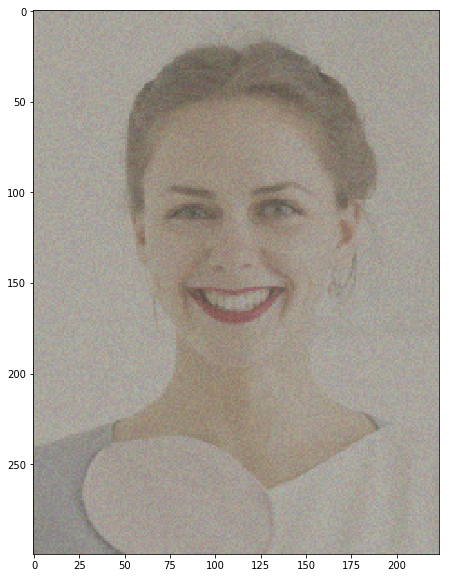

Step 0
    loss: 505352320.0
     Image saved. Time: 26.980830192565918


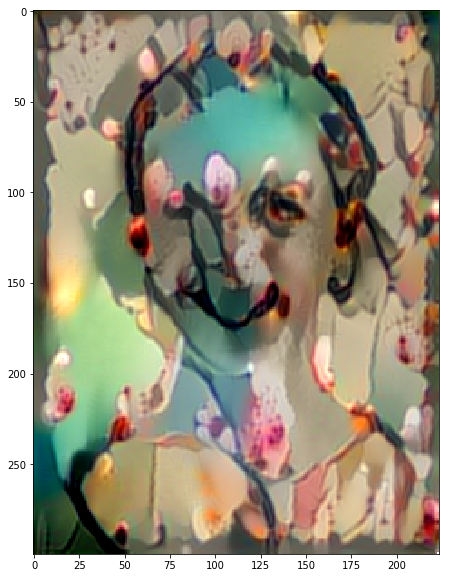

Step 1
    loss: 505314816.0
     Image saved. Time: 27.13033652305603


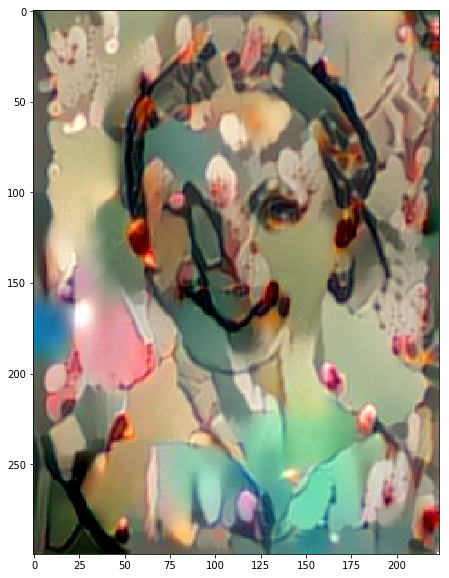

Step 2
    loss: 501091520.0
     Image saved. Time: 26.708616018295288


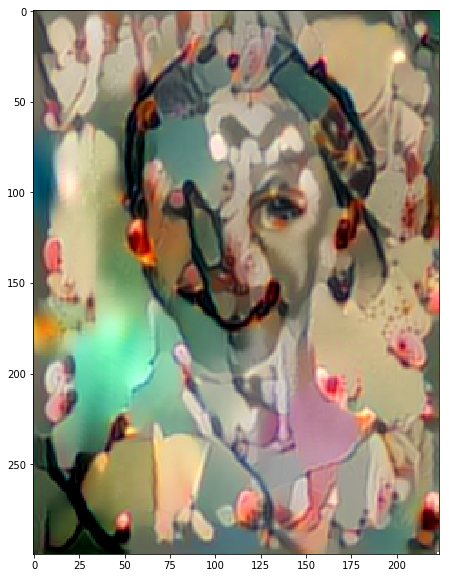

Step 3
    loss: 500526400.0
     Image saved. Time: 26.47554349899292


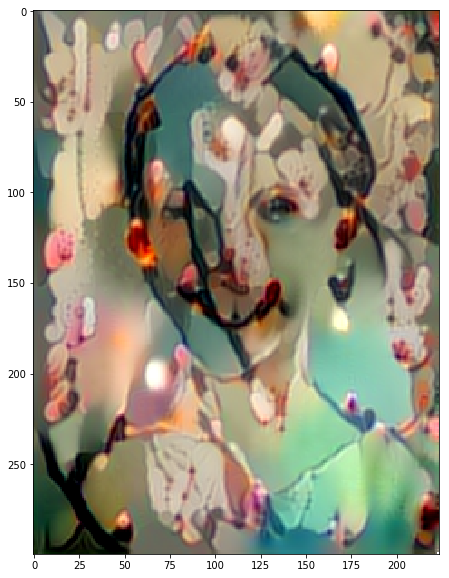

Step 4
    loss: 500960384.0
     Image saved. Time: 26.98956274986267


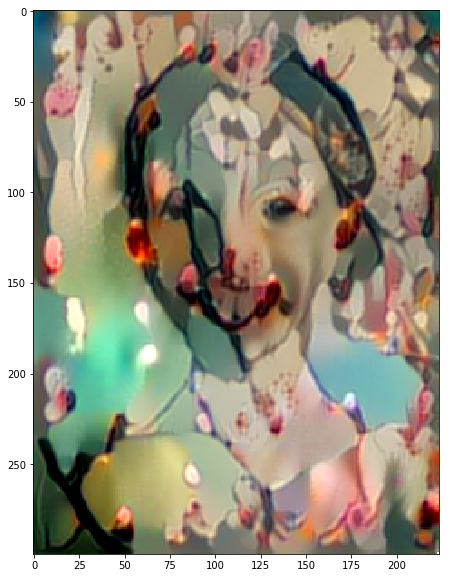

In [0]:
evaluator = Evaluator()

# Define the starting point for the generated image.
# We will use the content image as a starting point and add some noise.
gen_img = preprocess(INITIAL_GEN_IMAGE)
gen_img = add_noise(gen_img, NOISE_RATIO)

# Show image
plt.figure(figsize = (10,10))
imshow(deprocess_image(gen_img))
plt.show()

# Run the optimization several times to get (potentially) better results
for i in range(ITER):
    print('Step {}'.format(i))
    start_time = time.time()
    
    # Perform the optimization. 'fmin_l_bfgs_b' is an optimization algorithm.
    gen_img, min_val, info = fmin_l_bfgs_b(evaluator.loss, gen_img.flatten(), fprime=evaluator.grads, maxiter=300)
    
    print('    loss: {}'.format(min_val))
    
    # Save img
    img = deprocess_image(gen_img)
    imsave('output/img{}.jpg'.format(i), img)
    print('     Image saved. Time: {}'.format(time.time() - start_time))
    
    #Show img
    plt.figure(figsize = (10,10))
    imshow(img)
    plt.show()
    